In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [5]:
# Read the CSV file containing the labels
data = pd.read_csv('./Downloads/archive/PollenDataset/pollen_data.csv', usecols=['filename', 'pollen_carrying'])
data

filename  pollen_carrying
0     P10057-125r.jpg                1
1     P57380-120r.jpg                1
2    NP63671-221r.jpg                0
3     NP53776-47r.jpg                0
4    NP13382-201r.jpg                0
..                ...              ...
709  NP64239-233r.jpg                0
710  NP10304-132r.jpg                0
711  NP28671-238r.jpg                0
712   P14163-218r.jpg                1
713    NP1768-11r.jpg                0

[714 rows x 2 columns]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   filename         714 non-null    object
 1   pollen_carrying  714 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.3+ KB


In [7]:
def preprocess_df(df):
    df = df.copy()
    
    # Change filenames into filepaths
    image_path = './Downloads/archive/PollenDataset/images'
    df['filename'] = df['filename'].apply(lambda x: image_path / Path(x)).astype(str)
    
    # Create text labels for the images
    df['pollen_carrying'] = df['pollen_carrying'].map({0: "No Pollen", 1: "Pollen"})
    
    # Train-test split
    df_train, df_test = train_test_split(df, train_size=0.8, shuffle=True, random_state=0)
    
    return df_train, df_test

In [8]:
# Get preprocessed dataframes
df_train, df_test = preprocess_df(data)

In [9]:
# Create training generator
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create test generator
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [10]:
# Generate training images
train_images = train_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='filename',
    y_col='pollen_carrying',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

# Generate validation images
val_images = train_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='filename',
    y_col='pollen_carrying',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

# Generate test images
test_images = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='filename',
    y_col='pollen_carrying',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 457 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.
Found 143 validated image filenames belonging to 2 classes.


In [11]:
# First batch shape
test_images[0][0].shape # [batch number][0: image array / 1: label]

(32, 224, 224, 3)

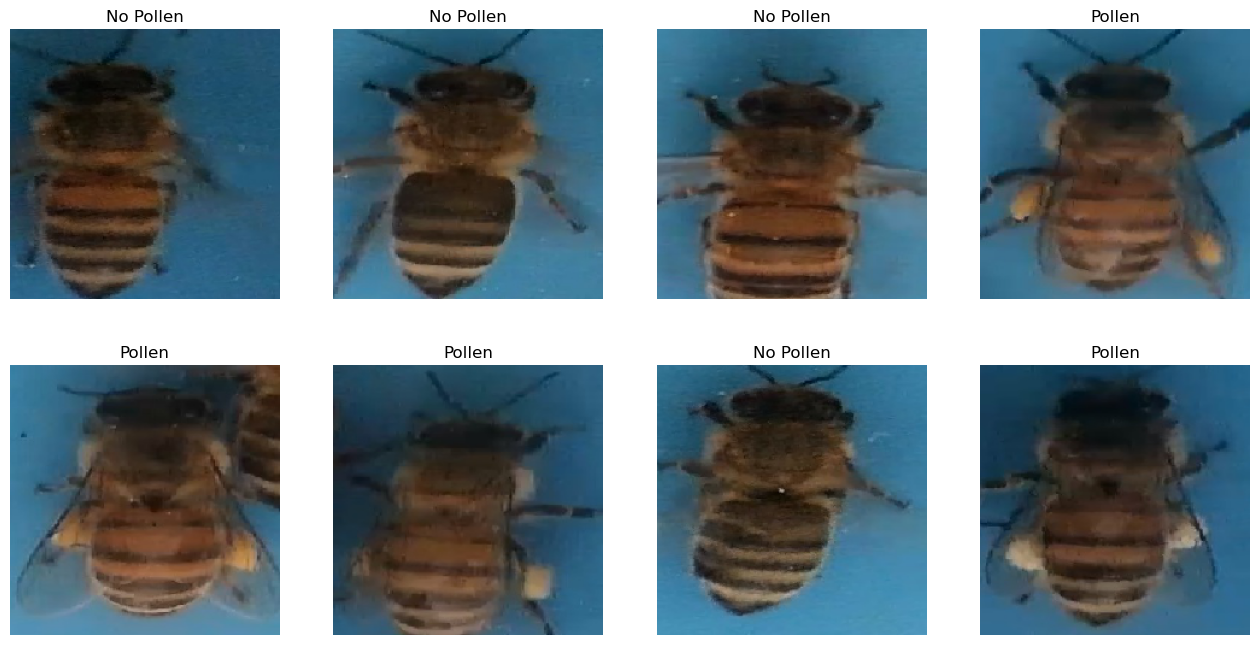

In [12]:
# Display of a few examples
plt.figure(figsize=(16, 8))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(test_images[0][0][i+10])
    plt.title("No Pollen" if test_images.labels[i+10] == 0 else "Pollen")
    plt.axis('off')
    
plt.show()

In [13]:
# Extract the features
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Classifier (standard neural network)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [14]:
# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# History
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
15/15 [==============================] - 11s 626ms/step - loss: 0.6967 - accuracy: 0.4814 - val_loss: 0.6930 - val_accuracy: 0.5088
Epoch 2/100
15/15 [==============================] - 7s 506ms/step - loss: 0.6943 - accuracy: 0.5208 - val_loss: 0.6947 - val_accuracy: 0.5088
Epoch 3/100
15/15 [==============================] - 8s 534ms/step - loss: 0.6927 - accuracy: 0.5208 - val_loss: 0.6941 - val_accuracy: 0.5088
Epoch 4/100
15/15 [==============================] - 7s 435ms/step - loss: 0.6926 - accuracy: 0.5208 - val_loss: 0.6939 - val_accuracy: 0.5088
Epoch 5/100
15/15 [==============================] - 7s 479ms/step - loss: 0.6922 - accuracy: 0.5208 - val_loss: 0.6934 - val_accuracy: 0.5088
Epoch 6/100
15/15 [==============================] - 7s 431ms/step - loss: 0.6917 - accuracy: 0.5208 - val_loss: 0.6926 - val_accuracy: 0.5088
Epoch 7/100
15/15 [==============================] - 7s 459ms/step - loss: 0.6911 - accuracy: 0.5208 - val_loss: 0.6917 - val_accuracy: 0.508

In [15]:
# Print accuracy (Percentage of correct predictions)
results = model.evaluate(test_images, verbose=0)
print("Accuracy: {:.2f} %".format(results[1] * 100))

Accuracy: 88.11 %


In [16]:
# Confusion matrix and classification report
predictions = np.squeeze(model.predict(test_images) >= 0.5).astype(int)
cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["No Pollen", "Pollen"])

5/5 [==============================] - 1s 122ms/step


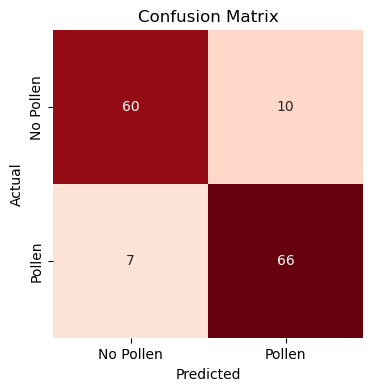

Classification Report:
----------------------
               precision    recall  f1-score   support

   No Pollen       0.90      0.86      0.88        70
      Pollen       0.87      0.90      0.89        73

    accuracy                           0.88       143
   macro avg       0.88      0.88      0.88       143
weighted avg       0.88      0.88      0.88       143



In [17]:
# Display
plt.figure(figsize=(4, 4))

sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Reds', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Pollen", "Pollen"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Pollen", "Pollen"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

print("Classification Report:\n----------------------\n", clr)

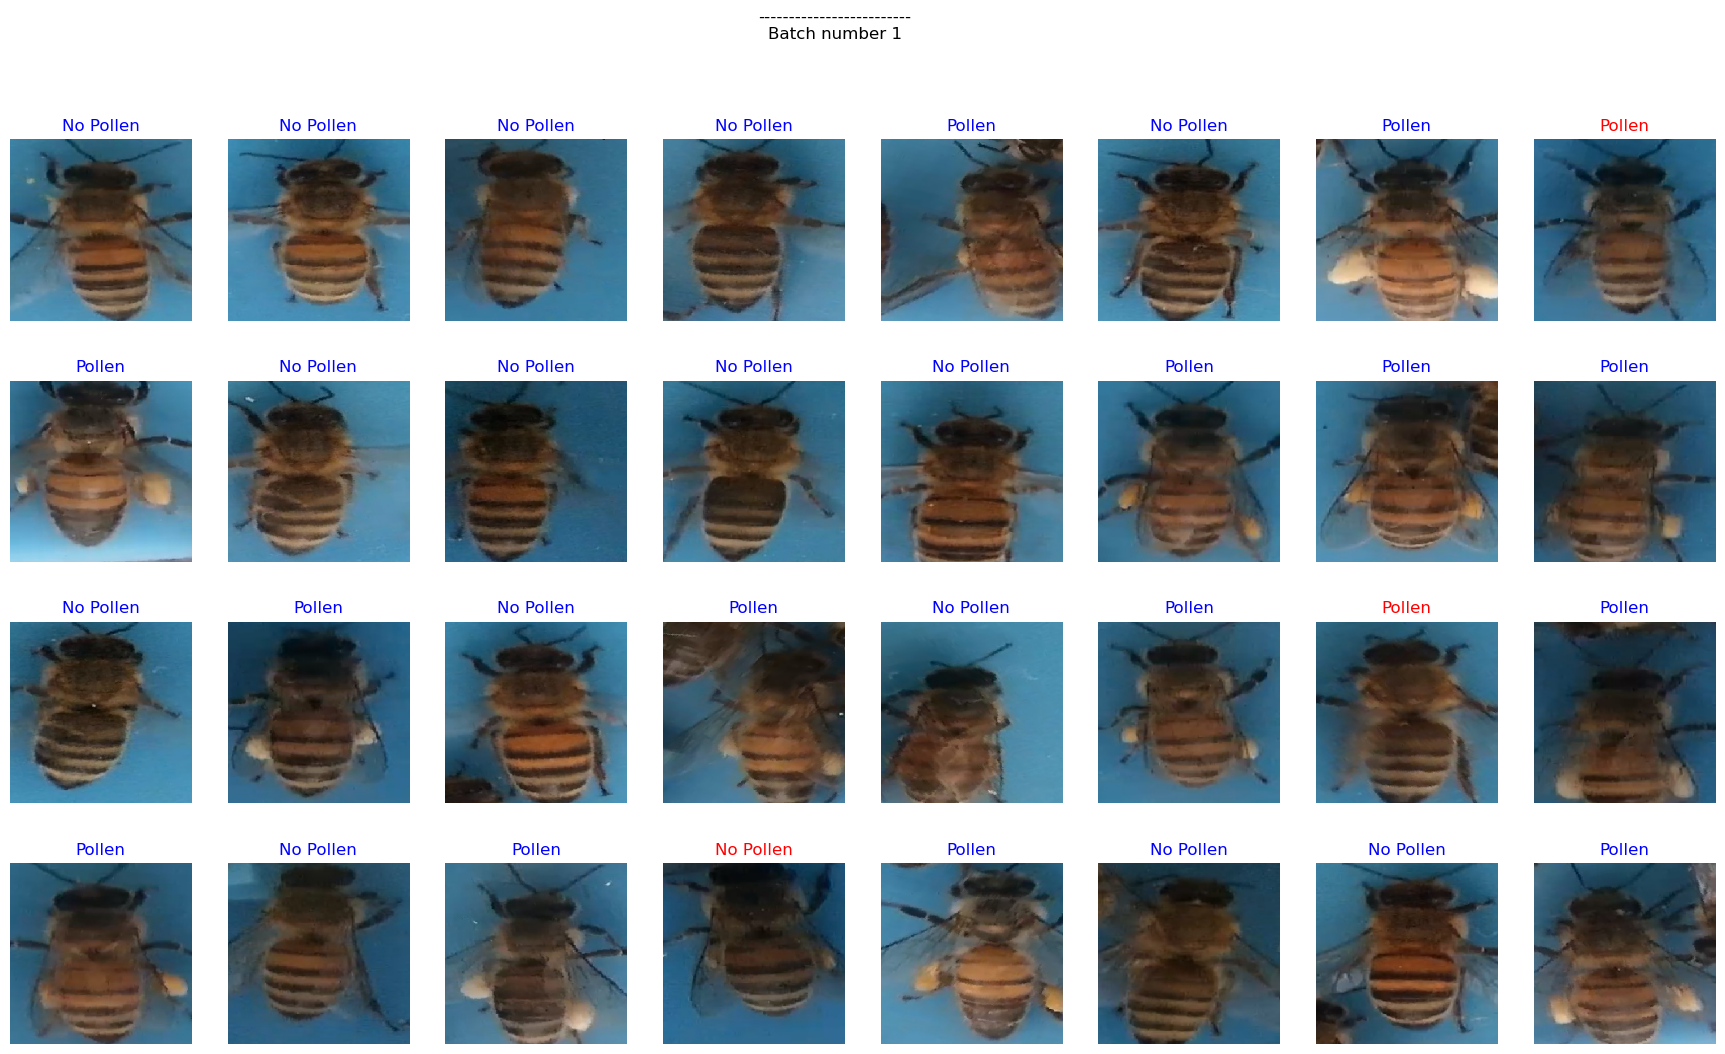

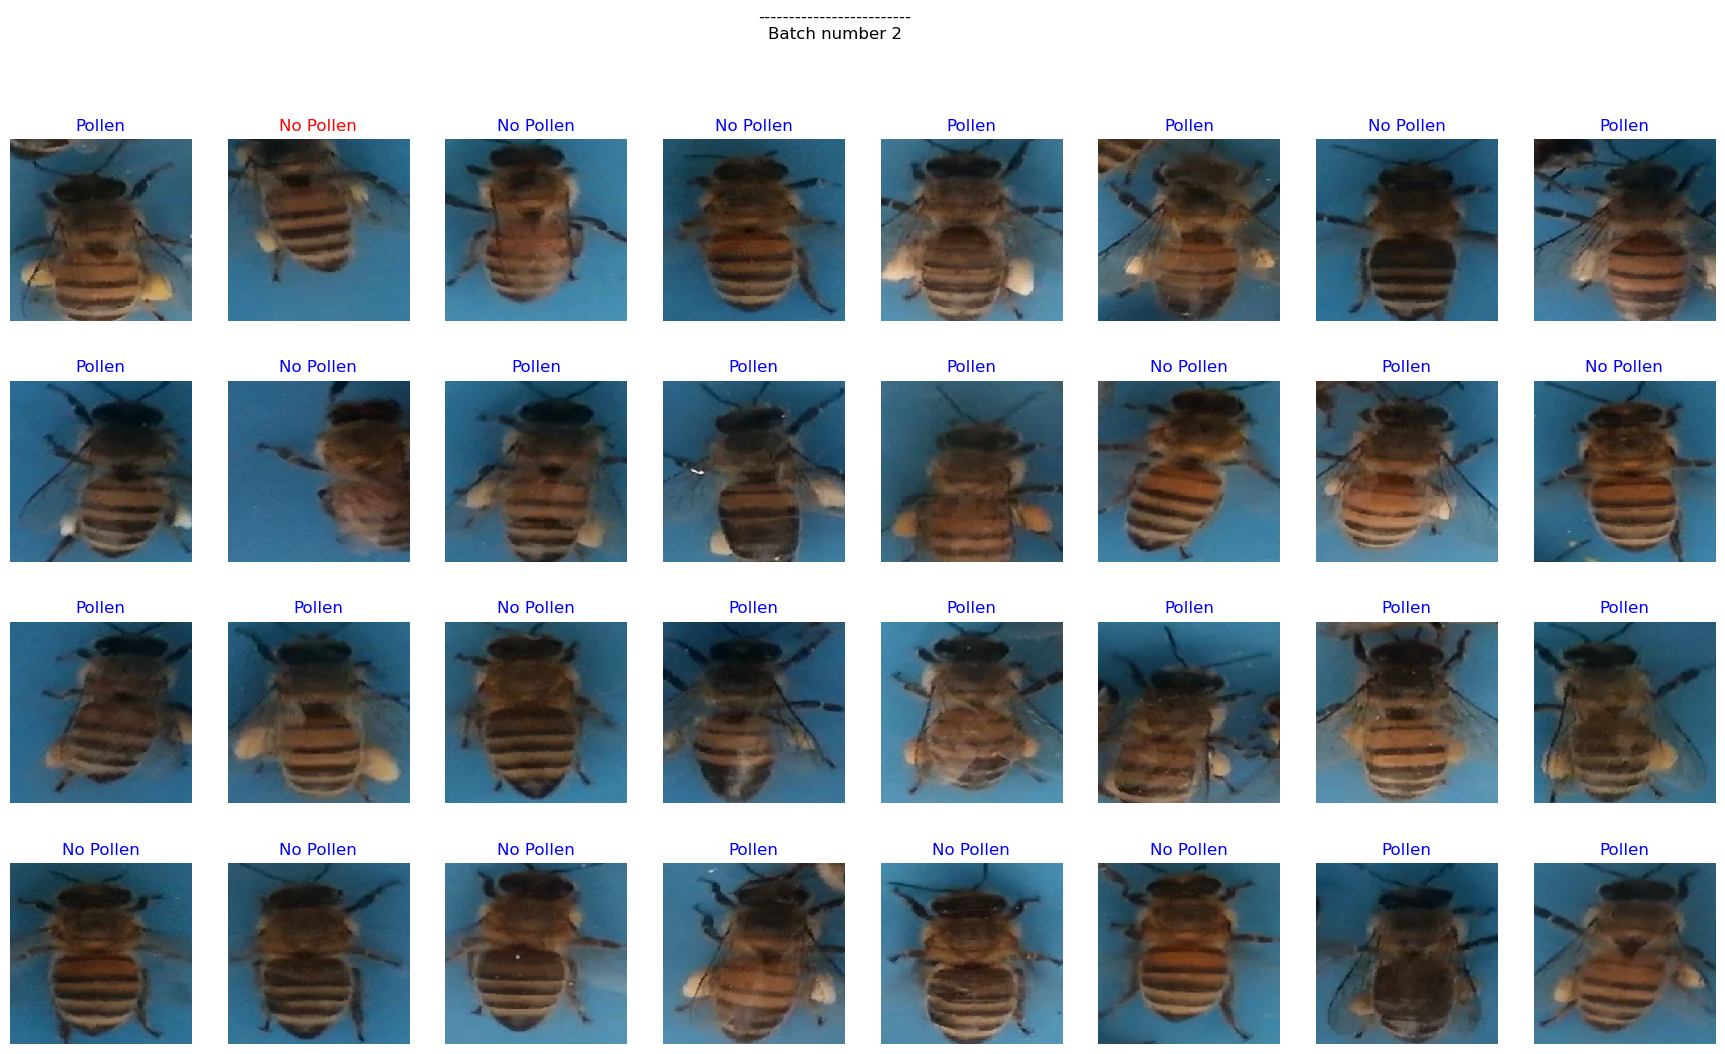

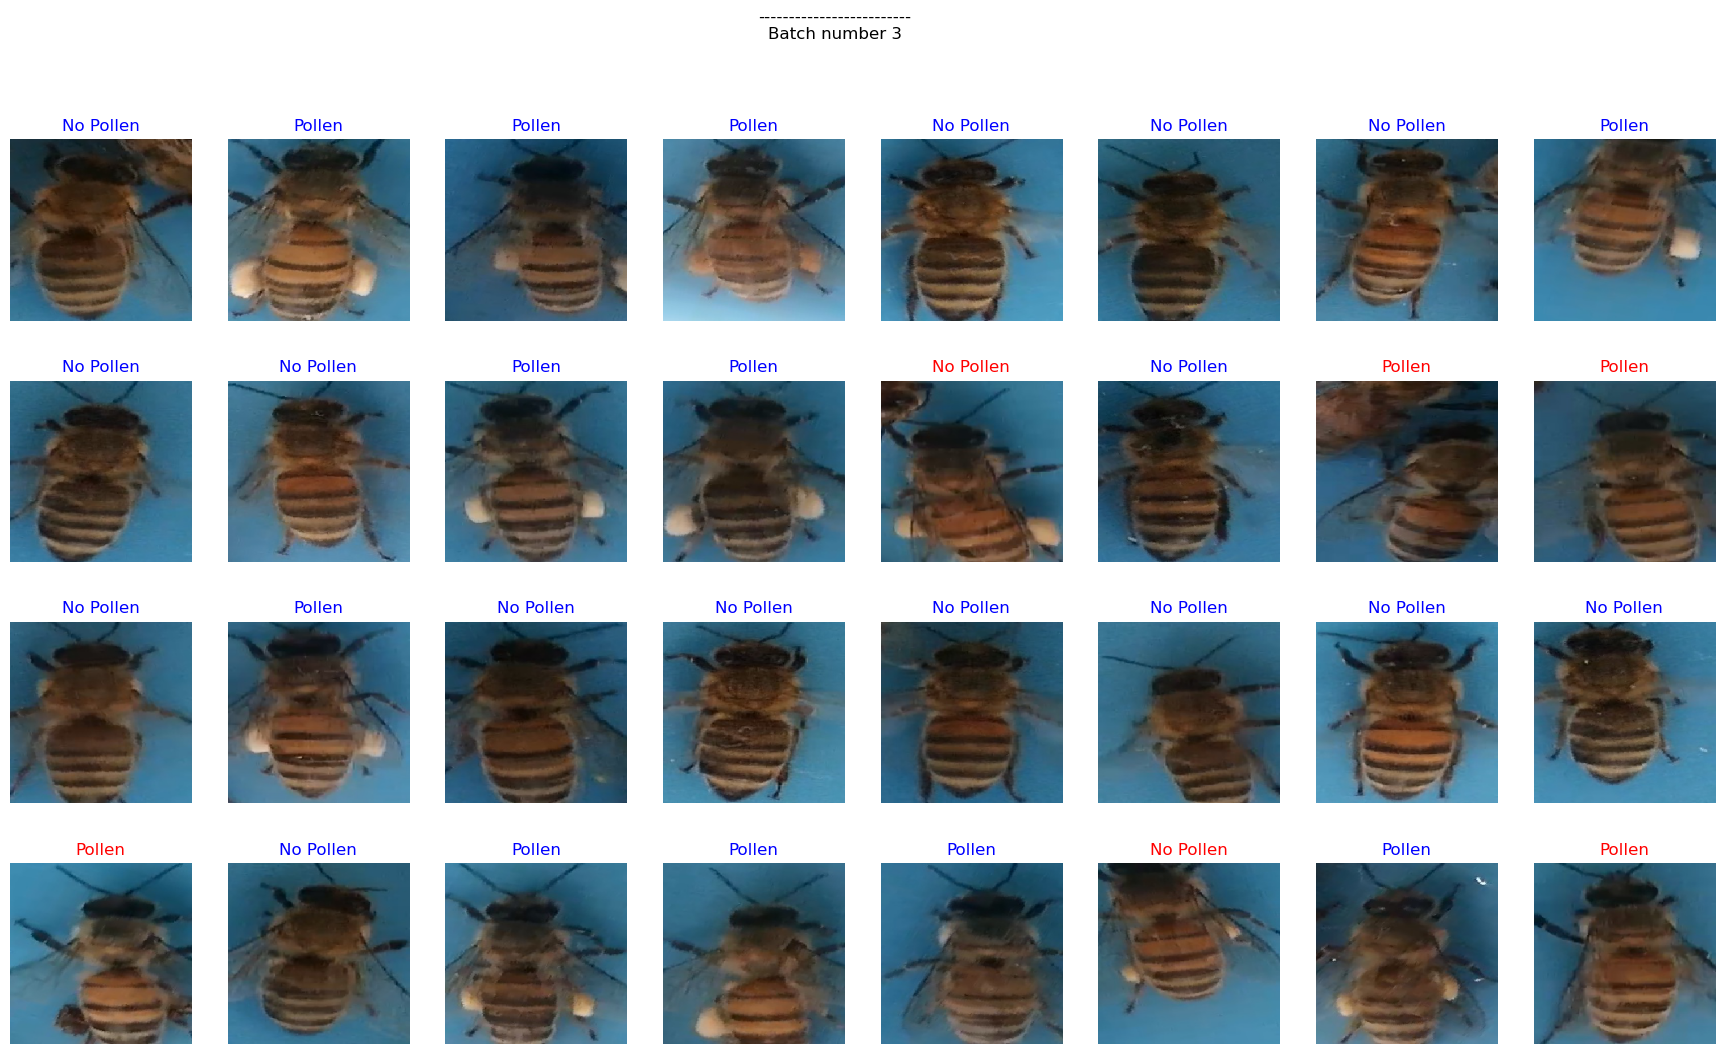

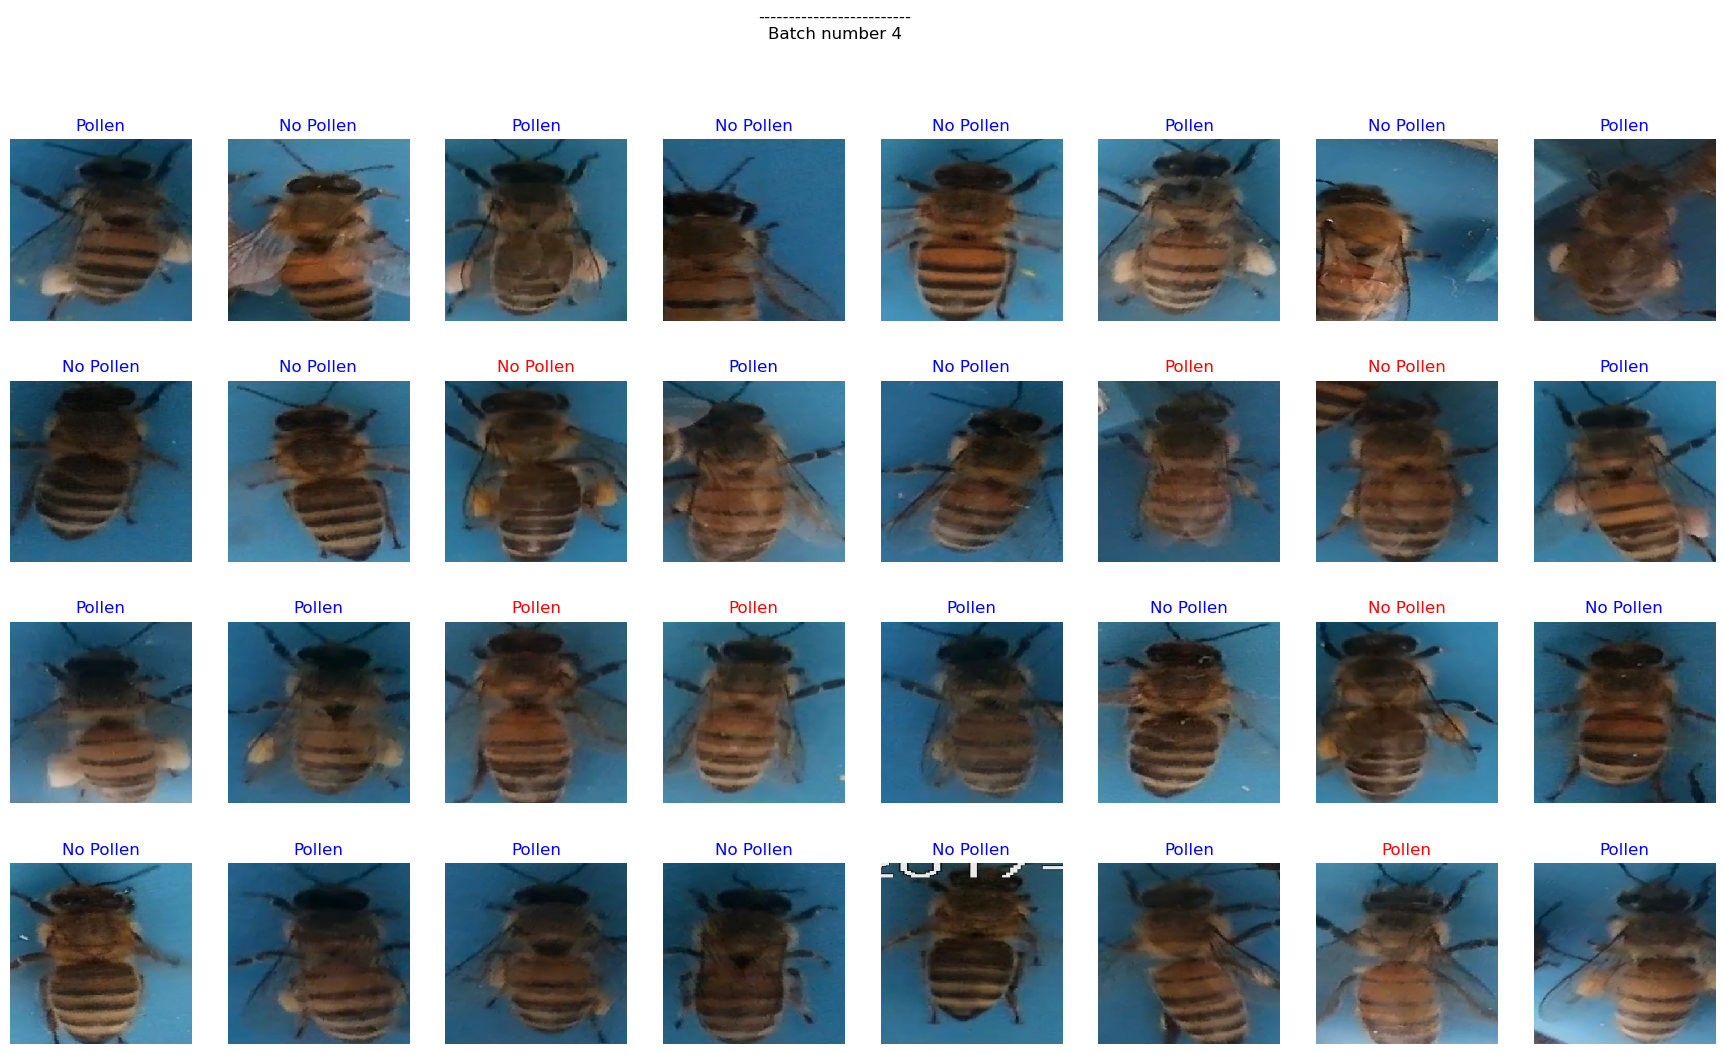

In [18]:
# Batch predictions
for batch in range(4):
    
    plt.figure(figsize=(22, 12))
    plt.suptitle(f"-------------------------\nBatch number {batch + 1}")
    
    for i in range(32):
        plt.subplot(4, 8, i+1)
        plt.imshow(test_images[batch][0][i])
        plt.title("No Pollen" if predictions[i+32*batch] == 0 else "Pollen",
                 color='blue' if predictions[i+32*batch] == test_images.labels[i+32*batch] else 'red')
        plt.axis('off')
    
plt.show()